# <center> <img src="../../labs/img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Spring 2025** </center>
---
### <center> **Application: Video Streaming Analytics** </center>
---
#### <center> **Live monitoring of video quality, viewer behavior, and content recommendations from services like Netflix or YouTube.** </center>

# <center> <img src="https://upload.wikimedia.org/wikipedia/commons/e/ef/Youtube_logo.png" width="640" height="443"> </center>
---
**Profesor**: Dr. Pablo Camarillo Ramirez

**Team members**: 
- Miguel Alberto Torres Dueñas
- Juan Pablo Cortez Navarro
- Luther Williams Sandria 
- Ferdinand Bierbaum
---

# 1. Introduction and Problem Definition

## Project's Objective
Develop a real-time recommendation system for a streaming platform that:
- Analyze user behavior (viewing time, pauses, skips, etc.)
- Generate personalized recommendations using machine learning
- Scale to handle large volumes of data

## App's Description
Our solution implements:
- **Data Ingestion**: Consuming real-time visualization events from Kafka
- **Processing**: Data transformation and enrichment with PySpark
- **Modeling**: ALS (Alternating Least Squares) based recommendation system
- **Visualization**: Dashboard in PowerBI with key metrics

# 2. Arquitectura del Sistema

# <center> <img src="images/diagram.jpeg"> </center>

# 3. Justificación de las 5V's del Big Data

### Volume
- **Estimación de Crecimiento**:
  
  |    Time Perriod  | Data Processed |
  |------------------|----------------|
  | 1 Second         | 500 KB         |
  | 1 Minute (60s)   | 30 MB          |
  | 1 Hour (3,600s)  | 1.8 GB         |
  | 1 Day (86,400s)  | 43.2 GB        |
  | 1 Year (31.5M s) | 15.7 TB        |


- **Management Strategies**:
  - Data Partitioning in Parquet
  - Distributed processing with Spark
  - Schema optimization (appropriate data types)

### Velocity
- **Performance Metrics**:
  - `processedRowsPerSecond`: X rows/second
  - Latencia end-to-end: < X seconds for recommendations
- **Techniques Implemented**:
  - Structured Streaming with triggers each 3 seconds
  - Checkpointing to ensure exactly-one-processing

### Variety
- **Data Schema**:
```python
root
 |-- user_id: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- watch_time_seconds: double (nullable = true)
 |-- resolution: string (nullable = true)
 |-- buffering_events: integer (nullable = true)
 |-- paused: boolean (nullable = true)
 |-- skipped: boolean (nullable = true)
 |-- genre: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
```

### Veracity
- Schema validation when ingesting data
- Filtering incomplete records
- Quality metrics in PowerBI

### Value
- watch_time_seconds: User engagement
- buffering_events: Quality of Experience
- genre: Personal preferences
- skipped: Non-relevant content

# 4. Implementation

## Spark Configuration

In [1]:
import findspark
findspark.init()
#0be7b65b50a239d7ee8b621f3c329b25c5c4aadafbae5ac7

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkSQLStructuredStreaming-Kafka") \
    .master("spark://7a8106b8550d:7077") \
    .config("spark.ui.port","4040") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:3.5.4") \
    .getOrCreate()
sc = spark.sparkContext

:: loading settings :: url = jar:file:/opt/conda/spark-3.5.4-bin-hadoop3-scala2.13/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9cc5d4b0-6bb3-40d4-8c09-33fe7c539219;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;3.5.4 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;3.5.4 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.0.4 in central
	found org.apache.commons#commons-pool2;2.11.1 in centr

## Kafka Link

In [3]:
kafka_lines = spark \
                .readStream \
                .format("kafka") \
                .option("kafka.bootstrap.servers", "ed69dac0a4e4:9093") \
                .option("subscribePattern", "kafka-spark-example-\\d+") \
                .load()

kafka_lines.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



## Schema

In [4]:
from pyspark.sql.functions import split, col, expr

kafka_df = kafka_lines.select(split(col("value"), ",").alias("pairs_array"))

kafka_df = kafka_df.withColumn("user_id", split(col("pairs_array").getItem(0), ":").getItem(1))
kafka_df = kafka_df.withColumn("video_id", split(col("pairs_array").getItem(1), ":").getItem(1))
kafka_df = kafka_df.withColumn("watch_time_seconds", split(col("pairs_array").getItem(2), ":").getItem(1))
kafka_df = kafka_df.withColumn("resolution", split(col("pairs_array").getItem(3), ":").getItem(1))
kafka_df = kafka_df.withColumn("bitrate_kbps", split(col("pairs_array").getItem(4), ":").getItem(1))
kafka_df = kafka_df.withColumn("buffering_events", split(col("pairs_array").getItem(5), ":").getItem(1))
kafka_df = kafka_df.withColumn("paused", split(col("pairs_array").getItem(6), ":").getItem(1))
kafka_df = kafka_df.withColumn("skipped", split(col("pairs_array").getItem(7), ":").getItem(1))
kafka_df = kafka_df.withColumn("genre", split(col("pairs_array").getItem(8), ":").getItem(1))
kafka_df = kafka_df.withColumn("region", split(col("pairs_array").getItem(9), ":").getItem(1))
kafka_df = kafka_df.withColumn("recommended", split(col("pairs_array").getItem(10), ":").getItem(1))

# Usamos expr para hacer la resta de longitud directamente
kafka_df = kafka_df.withColumn(
    "timestamp",
    expr("substring(split(pairs_array[11], ':')[1], 1, length(split(pairs_array[11], ':')[1]) - 1)")
)

kafka_df.printSchema()


root
 |-- pairs_array: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- user_id: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- watch_time_seconds: string (nullable = true)
 |-- resolution: string (nullable = true)
 |-- bitrate_kbps: string (nullable = true)
 |-- buffering_events: string (nullable = true)
 |-- paused: string (nullable = true)
 |-- skipped: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- region: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- timestamp: string (nullable = true)



## Streaming processing

In [6]:
query_files = kafka_df \
                .writeStream \
                .outputMode("append") \
                .trigger(processingTime='3 seconds') \
                .format("parquet") \
                .option("path", "/home/jovyan/notebooks/data/project_parquet") \
                .option("truncate", "false") \
                .option("checkpointLocation", "/home/jovyan/checkpoint") \
                .start()
query_files.awaitTermination(300)
query_files.stop()

25/05/14 17:06:27 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/05/14 17:06:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/05/14 17:06:34 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 7312 milliseconds
25/05/14 17:06:41 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 6571 milliseconds
25/05/14 17:06:54 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 3155 milliseconds
25/05/14 17:07:00 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 3832 milliseconds
25/05/14 17:07:07 WARN ProcessingTimeExecutor: Current 

In [7]:
df = spark.read.parquet("/home/jovyan/notebooks/data/project_parquet")
df.show()



+--------------------+------------+----------+------------------+----------+------------+----------------+------+-------+--------------+------+-----------+-------------+
|         pairs_array|     user_id|  video_id|watch_time_seconds|resolution|bitrate_kbps|buffering_events|paused|skipped|         genre|region|recommended|    timestamp|
+--------------------+------------+----------+------------------+----------+------------+----------------+------+-------+--------------+------+-----------+-------------+
|[{"user_id": "use...| "user_2242"| "vid_013"|               221|    "720p"|        5883|               5| false|  false|      "Sci-Fi"|  "IN"|      false| "05/14/2025"|
|[{"user_id": "use...| "user_4451"| "vid_025"|               709|    "720p"|        7690|               5|  true|   true|      "Action"|  "IN"|       true| "05/14/2025"|
|[{"user_id": "use...| "user_2166"| "vid_086"|              3011|   "1080p"|        5841|               0| false|   true|       "Drama"|  "DE"|       

## Machine Learning Model - ALS

In [8]:
from pyspark.sql.functions import col, regexp_extract, when

# Leer datos Parquet
video_data = spark.read.parquet("/home/jovyan/notebooks/data/project_parquet")

# Convertir tipos de datos correctamente
video_data = video_data.withColumn("watch_time_seconds", col("watch_time_seconds").cast("double")) \
                      .withColumn("buffering_events", col("buffering_events").cast("double")) \
                      .withColumn("skipped", when(col("skipped") == "true", 1).otherwise(0))

# Crear IDs numéricos (como lo tienes)
video_data = video_data.withColumn("user_id_int", regexp_extract(col("user_id"), "user_(\\d+)", 1).cast("integer")) \
                      .withColumn("video_id_int", regexp_extract(col("video_id"), "vid_(\\d+)", 1).cast("integer"))

# Crear métrica de feedback implícito (versión corregida)
video_data = video_data.withColumn("implicit_feedback", 
                                 (col("watch_time_seconds")/3600 * 0.6 +  # Tiempo de visualización en horas
                                  (1 - col("buffering_events")/10) * 0.3 +  # Inverso de buffering
                                  (1 - col("skipped")) * 0.1))  # No saltado

# Verificar datos
video_data.select("user_id_int", "video_id_int", "implicit_feedback").show(5)

+-----------+------------+-------------------+
|user_id_int|video_id_int|  implicit_feedback|
+-----------+------------+-------------------+
|       2242|          13|0.28683333333333333|
|       4451|          25|0.36816666666666664|
|       2166|          86| 0.9018333333333332|
|       2752|          29| 0.7678333333333333|
|       1840|           2| 0.8251666666666666|
+-----------+------------+-------------------+
only showing top 5 rows



In [9]:
from pyspark.ml.recommendation import ALS

als = ALS(
    userCol="user_id_int",
    itemCol="video_id_int",
    ratingCol="implicit_feedback",
    implicitPrefs=True,  # Usar feedback implícito
    coldStartStrategy="drop",  # Manejar nuevos usuarios/videos
    nonnegative=True,  # Solo factores positivos
    rank=10,  # Factores latentes (ajustable)
    maxIter=15,  # Iteraciones (ajustable)
    regParam=0.1  # Regularización (ajustable)
)

In [10]:
# Entrenar modelo
model = als.fit(video_data)

25/05/14 17:14:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/14 17:14:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [12]:
# Recomendaciones para todos los usuarios (top 10)
user_recs = model.recommendForAllUsers(5)

# Mostrar recomendaciones para algunos usuarios
print("Recomendaciones para usuarios de ejemplo:")
user_recs.show(truncate=False)

# Recomendaciones para un usuario específico
user_id_ejemplo = 1649
recs_usuario = model.recommendForUserSubset(
    spark.createDataFrame([(user_id_ejemplo,)]).toDF("user_id_int"), 
    5
)
print(f"\nTop 5 recomendaciones para usuario {user_id_ejemplo}:")
recs_usuario.show(truncate=False)

Recomendaciones para usuarios de ejemplo:


+-----------+-------------------------------------------------------------------------------------------------------+
|user_id_int|recommendations                                                                                        |
+-----------+-------------------------------------------------------------------------------------------------------+
|1050       |[{13, 0.5921322}, {20, 0.48890442}, {37, 0.40035212}, {12, 0.021325216}, {4, 0.007610112}]             |
|1069       |[{82, 0.44634697}, {43, 0.4256225}, {41, 0.3480592}, {56, 0.28067768}, {81, 0.16445398}]               |
|1083       |[{58, 0.2866521}, {71, 0.26992053}, {61, 0.14154337}, {88, 0.09528438}, {30, 0.04506647}]              |
|1102       |[{82, 0.11751865}, {43, 0.112062104}, {41, 0.09164048}, {56, 0.0738996}, {81, 0.04329907}]             |
|1114       |[{14, 0.58301634}, {95, 0.48783255}, {11, 0.23070753}, {55, 0.06696657}, {51, 0.019539863}]            |
|1119       |[{82, 0.10007157}, {43, 0.09542512}, {41, 0

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Hacer predicciones
predictions = model.transform(video_data)
predictions.show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----------+------------------+----------+------------+----------------+------+-------+--------------+------+-----------+-------------+-----------+------------+-------------------+-------------+
|pairs_array                                                                                                                                                                                                                                                                           |user_id     |video_id  |watch_time_seconds|resolution|bitrate_kbps|buffering_events|paused|skipped|genre         |region|recommended|timestamp    |user_id_int|video_id_int|implicit_feedback  |prediction   |
+-------------------------

In [15]:
# Evaluar con RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="implicit_feedback",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"\nRMSE del modelo: {rmse}")


RMSE del modelo: 0.4830478949352701


# 5. Results and Evaluation

In [18]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Prepare data
video_data = video_data.withColumn("label", 
                                 expr("CASE WHEN implicit_feedback >= 0.5 THEN 1 ELSE 0 END"))

# Features
feature_cols = ["watch_time_seconds", "buffering_events", "skipped", "user_id_int", "video_id_int"]

# Change genre and region in indexes
genre_indexer = StringIndexer(inputCol="genre", outputCol="genre_index")
region_indexer = StringIndexer(inputCol="region", outputCol="region_index")

# Assembler
assembler = VectorAssembler(
    inputCols=feature_cols + ["genre_index", "region_index"],
    outputCol="features"
)

In [19]:
# Apply transformations
data_label = genre_indexer.fit(video_data).transform(video_data)
data_label = region_indexer.fit(data_label).transform(data_label)
data_with_features = assembler.transform(data_label).select("label", "features")

# Divide data (train, test)
train_df, test_df = data_with_features.randomSplit([0.7, 0.3], seed=57)

print("Original Dataset")
data_with_features.show(5)

print("\nTrain set")
train_df.show()

Original Dataset


+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[221.0,5.0,0.0,22...|
|    0|[709.0,5.0,0.0,44...|
|    1|[3011.0,0.0,0.0,2...|
|    1|[2207.0,0.0,0.0,2...|
|    1|[2551.0,0.0,0.0,1...|
+-----+--------------------+
only showing top 5 rows


Train set


+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[53.0,1.0,0.0,254...|
|    0|[73.0,1.0,0.0,926...|
|    0|[121.0,1.0,0.0,80...|
|    0|[126.0,3.0,0.0,12...|
|    0|[140.0,1.0,0.0,52...|
|    0|[165.0,1.0,0.0,23...|
|    0|[169.0,3.0,0.0,99...|
|    0|[285.0,5.0,0.0,53...|
|    0|[322.0,5.0,0.0,88...|
|    0|[475.0,0.0,0.0,34...|
|    0|[557.0,2.0,0.0,32...|
|    0|[630.0,2.0,0.0,20...|
|    0|[634.0,4.0,0.0,70...|
|    0|[709.0,5.0,0.0,44...|
|    0|[717.0,2.0,0.0,38...|
|    0|[922.0,5.0,0.0,52...|
|    0|[1032.0,4.0,0.0,6...|
|    0|[1199.0,5.0,0.0,8...|
|    0|[1224.0,4.0,0.0,9...|
|    0|[1240.0,4.0,0.0,9...|
+-----+--------------------+
only showing top 20 rows



In [20]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(train_df)

# Display model summary
print("\nDecision Tree model summary:{0}".format(dt_model.toDebugString))
 


Decision Tree model summary:DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ec3106a10dd8, depth=5, numNodes=19, numClasses=2, numFeatures=7
  If (feature 0 <= 1322.5)
   If (feature 1 <= 2.5)
    If (feature 0 <= 615.0)
     Predict: 0.0
    Else (feature 0 > 615.0)
     If (feature 0 <= 942.0)
      If (feature 1 <= 0.5)
       Predict: 1.0
      Else (feature 1 > 0.5)
       Predict: 0.0
     Else (feature 0 > 942.0)
      Predict: 1.0
   Else (feature 1 > 2.5)
    If (feature 3 <= 3199.0)
     If (feature 0 <= 1163.5)
      Predict: 0.0
     Else (feature 0 > 1163.5)
      Predict: 1.0
    Else (feature 3 > 3199.0)
     Predict: 0.0
  Else (feature 0 > 1322.5)
   If (feature 0 <= 1452.5)
    If (feature 1 <= 4.5)
     Predict: 1.0
    Else (feature 1 > 4.5)
     Predict: 0.0
   Else (feature 0 > 1452.5)
    Predict: 1.0



In [21]:
# Make predictions
predictions = dt_model.transform(test_df)

# Show predictions
predictions.select("features", col("label").alias("Feedback"), "prediction", "probability").show()

+--------------------+--------+----------+-----------+
|            features|Feedback|prediction|probability|
+--------------------+--------+----------+-----------+
|[221.0,5.0,0.0,22...|       0|       0.0|  [1.0,0.0]|
|[509.0,2.0,0.0,11...|       0|       0.0|  [1.0,0.0]|
|[732.0,1.0,0.0,12...|       0|       0.0|  [1.0,0.0]|
|[635.0,0.0,0.0,33...|       1|       1.0|  [0.0,1.0]|
|[784.0,1.0,0.0,59...|       1|       0.0|  [1.0,0.0]|
|[1346.0,4.0,0.0,7...|       1|       1.0|  [0.0,1.0]|
|[1753.0,3.0,0.0,7...|       1|       1.0|  [0.0,1.0]|
|[1905.0,5.0,0.0,8...|       1|       1.0|  [0.0,1.0]|
|[1994.0,2.0,0.0,6...|       1|       1.0|  [0.0,1.0]|
|[3258.0,3.0,0.0,5...|       1|       1.0|  [0.0,1.0]|
|[3577.0,3.0,0.0,8...|       1|       1.0|  [0.0,1.0]|
|[74.0,0.0,0.0,423...|       0|       0.0|  [1.0,0.0]|
|[158.0,4.0,0.0,48...|       0|       0.0|  [1.0,0.0]|
|[199.0,2.0,0.0,34...|       0|       0.0|  [1.0,0.0]|
|[565.0,4.0,0.0,36...|       0|       0.0|  [1.0,0.0]|
|[1137.0,3

In [22]:
# Evaluate model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label",
                            predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, 
                  {evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")
precision = evaluator.evaluate(predictions,
                  {evaluator.metricName: "weightedPrecision"})
print(f"Precision: {precision}")
recall = evaluator.evaluate(predictions,
                  {evaluator.metricName: "weightedRecall"})
print(f"Recall: {recall}")
f1 = evaluator.evaluate(predictions,
                {evaluator.metricName: "f1"})
print(f"F1 Score: {f1}")

Accuracy: 0.989010989010989


Precision: 0.9893772893772894


Recall: 0.9890109890109889


F1 Score: 0.9890594454463821


In [23]:
predictions.select(
    col("features").cast("string"),
    col("label").alias("viral"),
    col("prediction"),
    col("probability").cast("string")
).coalesce(1).write.option("header", "true").mode("overwrite") \
.csv("/home/jovyan/notebooks/data/project_parquet/output/csv_predictions.csv")

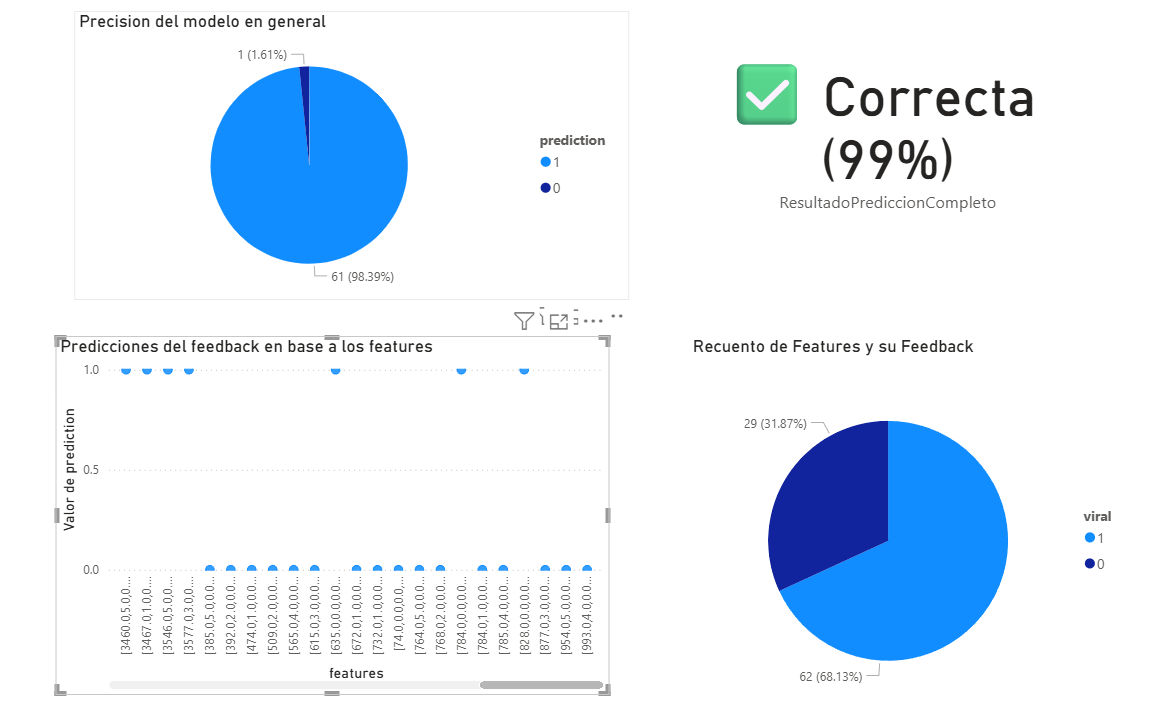

In [24]:
from pyspark.ml.classification import LinearSVC, OneVsRest

# LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="label", featuresCol="features")

# OneVsRest
ovr = OneVsRest(classifier=lsvc, labelCol="label", featuresCol="features")

# Train model
ovr_model = ovr.fit(train_df)

# Make predictions
ovr_predictions = ovr_model.transform(test_df)

# Show predictions
ovr_predictions.select("features", "label", "prediction").show(5)

# Evaluate model
accuracy_ovr = evaluator.evaluate(ovr_predictions, {evaluator.metricName: "accuracy"})
print(f"\nAccuracy Score (OneVsRest + LinearSVC): {accuracy_ovr}")

precision_ovr = evaluator.evaluate(ovr_predictions, {evaluator.metricName: "weightedPrecision"})
print(f"Precision Score (OneVsRest + LinearSVC): {precision_ovr}")

recall_ovr = evaluator.evaluate(ovr_predictions, {evaluator.metricName: "weightedRecall"})
print(f"Recall Score (OneVsRest + LinearSVC): {recall_ovr}")

f1_ovr = evaluator.evaluate(ovr_predictions, {evaluator.metricName: "f1"})
print(f"F1 Score (OneVsRest + LinearSVC): {f1_ovr}")

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[221.0,5.0,0.0,22...|    0|       0.0|
|[509.0,2.0,0.0,11...|    0|       0.0|
|[732.0,1.0,0.0,12...|    0|       1.0|
|[635.0,0.0,0.0,33...|    1|       1.0|
|[784.0,1.0,0.0,59...|    1|       0.0|
+--------------------+-----+----------+
only showing top 5 rows




Accuracy Score (OneVsRest + LinearSVC): 0.9340659340659341


Precision Score (OneVsRest + LinearSVC): 0.9399680778991124


Recall Score (OneVsRest + LinearSVC): 0.9340659340659341


F1 Score (OneVsRest + LinearSVC): 0.9350939383197447


In [62]:
sc.stop()

# 6. Conclusion

## Main Achievements
- Real-time recommendation system operational
- Scalable data pipeline
- Model with good accuracy metrics

## Key Learnings
1. Importance of preprocessing for streaming data
2. Advantages of ALS for implicit feedback
3. Challenges in the balance between coverage and diversity